<a href="https://colab.research.google.com/github/PedroDS4/Sistema_de_comunicacoes/blob/main/Project_comunication_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sistema de Transmissão de dados idealizado**
O sistema de transmissão de dados implementado nesse código fará a simulação realista de um sistema, considerando os efeitos de canal e todas as etapas do transmissor e receptor



##**Funções importantes**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz, convolve


##################Funções importantes do transmissor############################
def letrapam(string):
  """
  Codifica uma string usando 4-PAM.

  Args:
    string: A string a ser codificada.

  Returns:
    Um array NumPy contendo os símbolos 4-PAM codificados.
  """

  # Converte a string em uma sequência de bits
  bits = ''.join(format(ord(c), '08b') for c in string)

  # Mapeia os bits para símbolos 4-PAM
  symbols = []
  for i in range(0, len(bits), 2):
    dibits = bits[i:i+2]
    if dibits == '00':
      symbols.append(-3)
    elif dibits == '01':
      symbols.append(-1)
    elif dibits == '10':
      symbols.append(1)
    elif dibits == '11':
      symbols.append(3)

  return np.array(symbols)

def pamdecod(symbols):
  """
  Decodifica símbolos 4-PAM em uma string.

  Args:
    symbols: Um array NumPy contendo os símbolos 4-PAM.

  Returns:
    A string decodificada.
  """

  # Mapeia os símbolos 4-PAM de volta para bits
  bits = ''
  for symbol in symbols:
    if symbol == -3:
      bits += '00'
    elif symbol == -1:
      bits += '01'
    elif symbol == 1:
      bits += '10'
    elif symbol == 3:
      bits += '11'

  # Converte a sequência de bits de volta para uma string
  string = ''.join(chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8))

  return string


def raised_cosine(t, T, beta):
    p = np.zeros_like(t)
    for i in range(len(t)):
        if abs(2 * beta * t[i] / T) == 1:
            p[i] = np.pi / 4 * T
        else:
            p[i] = (np.sin(np.pi * t[i] / T) / (np.pi * t[i] / T)) * \
                   (np.cos(np.pi * beta * t[i] / T) / (1 - (2 * beta * t[i] / T)**2))
    return p





########################Funções importantes do receptor#########################
def quantizador(x,niveis):
  """
    Quantiza um sinal com base em níveis fornecidos.

    Args:
        x: Sinal de entrada.
        niveis: Array de níveis de quantização.

    Returns:
        Sinal quantizado.
  """

  L = len(niveis)
  N = len(x)
  x_q = np.zeros(N,dtype = int)
  for i in range(N):
    xq_i = x[i]
    e = niveis - xq_i
    j = np.argmin(np.abs(e))
    x_q[i] = niveis[j]

  return x_q



def J2(a,r,d):
  mean = 0
  N = len(r)

  for i in range(N):
    s = a*r[i]
    mean = mean + abs(a)*((s**2)/2 - d**2)

  return mean/(N)


def grad_j2(a,r,d):
  grad = 0
  N = len(r)

  for i in range(N):
    s = a*r[i]
    grad = grad + np.sign(a)*(s**2 - d**2)

  return grad/N



def AGC(x_r,d,n_iter,mu):
  a_vector = np.zeros(n_iter)
  a_vector[0] = 1

  #Valor RMS de referência
  d = d/np.sqrt(2)

  J_vector = np.zeros(n_iter)
  for i in range(n_iter-1):
    a_vector[i+1] = a_vector[i] - mu*grad_j2(a_vector[i],x_r,d)
    J_vector[i] = J2(a_vector[i+1],x_r,d)



  return a_vector[n_iter-1]*x_r




In [ ]:
# Exemplo de uso
symbols = np.array([-3, -1, 1, 3, -3, -1, 1, 3])
string = pamdecod(symbols)
print(string)
# Exemplo de uso
string = "Olá mundo"
symbols = letrapam(string)
string_rec = pamdecod(symbols)
print(string_rec)
print(symbols)


Olá mundo
[-1 -3  3  3 -1  1  3 -3  3  1 -3 -1 -3  1 -3 -3 -1  1  3 -1 -1  3 -1 -1
 -1  1  3  1 -1  1 -1 -3 -1  1  3  3]


##**Transmissor**
As etapas do transmissor são
* Codificação
* Filtro de pulso
* Modulação
* Transmissão ao Canal

Essas etapas serão implementadas abaixo, e sua matemática será descrita abaixo.


### **Matemática da Transmissão**
**Codificação**
A codificação é o ato de transformar os caracteres em string que irão ser transmitidos em bits, por exemplo

$$
"A"  -> 0100 0001
$$

$$
"B"  -> 0100 0010
$$

essa conversão pode ser encontrada diretamente na tabela ASCII, e existem funções que ja fazem essa conversão.


Então seja uma sequência a ser transmitida, como por exemplo abaixo

$$
Str = "Olá \ mundo"
$$

Quando codificada, gera-se um vetor com os bits dos símbolos, que depois irá ser convertido em números únicos

$$
s = letrapam(str)
$$

O tipo de codificação será uma 4-PAM
dada pela relação

00 -> -3

01 -> -1

10 ->  1

11 -> 3



**Filtro de pulso**
Depois da codificação, os símbolos dos caracteres precisam ser armazenados em um vetor, para serem transformados em um sinal analógico.

Esse vetor em que os simbolos são adicionados, pode ser representado por um trem de impulsos, dado por

$$
s[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM]
$$


e esse sinal de simbolos é convoluído com uma forma de pulso, $p[n]$, e o sinal resultante que será transmitido, fica

$$
x[n] = s[n] \ast p[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM] \ast p[n]
$$

então

$$
x[n] =  \sum_{k = 0}^{M} s_k \cdot (p[n] \ast \delta[n-kM]) = \sum_{k = 0}^{M} s_k p[n - kM]
$$

e o sinal $x[n]$ é passado por um conversor D/A para a modulação e posteriormente transmissão.

**Modulação**
A modulação é o ato de deslocarmos o sinal em frequẽncia, para poder transmití-la em um certo canal
Matematicamente é dada por

$$
x_{m}(t) = x(t) \cdot cos(2\pi f_c t)
$$


na frequência, o que acontece é


$$
X_m(f) = \frac{1}{2}X(f) \delta(f - fc) + \frac{1}{2}X(f) \delta(f + fc)
$$

ou seja, o espectro do sinal é deslocado para a frequência do cosseno.






[-1 -1 -3  3 -1  1  1 -1 -1  3 -3  3 -1  3 -1 -3 -1  1 -1 -1 -1  1  3 -1
 -1  1 -3 -1 -3  1 -3 -3 -1  1 -1 -3 -1  1 -1 -1 -3  1 -3 -3 -1  3 -1 -3
 -1  3 -3  1 -1  1 -3 -1 -1  1  3  1 -1  3 -3  3 -1  1  3 -1 -1  1  1 -1
 -1  3 -3  3 -1  3 -3  3  3  1 -3  3 -1  1  3  3 -3  1 -3 -3 -1  1 -1 -3
 -1  1  1 -1 -1  1 -1  3 -1  1  1 -1 -1  3 -1 -3 -1  1 -3 -1 -1  1  3 -3]
[-1.  0.  0. ...  0.  0.  0.]


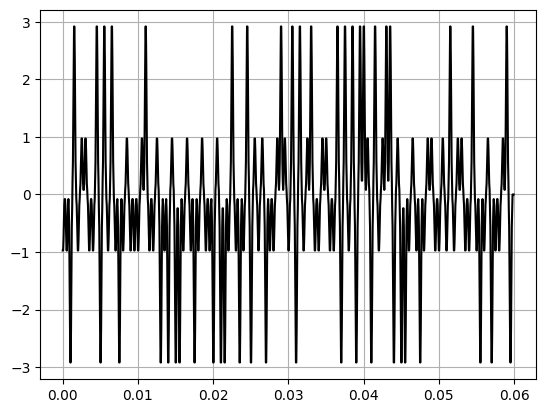

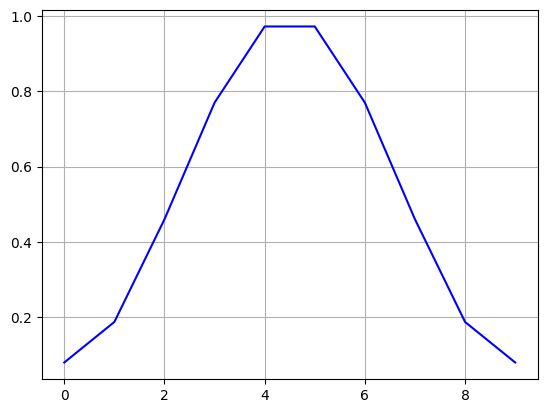

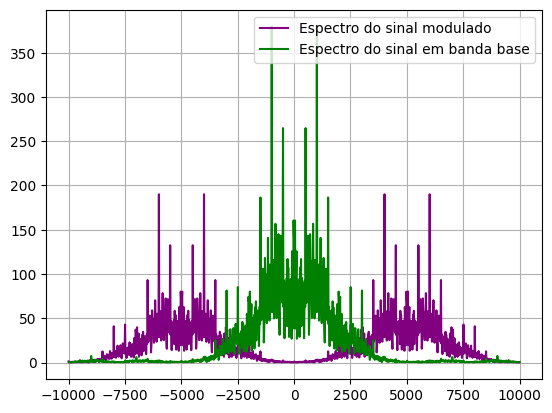

In [ ]:
#Exemplo de uma transmissão de um sinal
#Codificação
mensagem = "Sistema de transmissão digital"
s = letrapam(mensagem)
N = len(s)
M = 10
mup = np.zeros(N*M)
for i in range(N):
  mup[i*M] = s[i]

#Filtro de pulso
Ts = 1/20000
Fs = 1/Ts
A1 = 1
B = 1
t = np.linspace(-1,1,M)



#Testes de pulsos
p_nyquist = A1*np.sin(2*np.pi*B*t)/(np.pi*t)
p_nyquist[0] = 2*A1*B

p_hamming = np.hamming(M)

p_rc = raised_cosine(t, Ts, 1)
p_rc = p_rc/np.linalg.norm(p_rc)



x = np.convolve(mup,p_hamming,'same')
t_x = np.arange(0,len(x)*Ts,Ts)


#Modulação
fc = 5000
x_m = x * np.cos(2*np.pi*fc*t_x)

print(s)
print(mup)
plt.plot(t_x,x,'black')
plt.grid()
plt.show()


plt.plot(p_hamming,'blue')
plt.grid()
plt.show()

X = np.fft.fftshift(np.fft.fft(x))
X_m = np.fft.fftshift(np.fft.fft(x_m))
f = np.linspace(-1/(2*Ts),1/(2*Ts),len(x_m))
plt.figure()
plt.plot(f,np.abs(X_m),color = 'purple',label = "Espectro do sinal modulado")
plt.plot(f,np.abs(X),color = 'green',label = "Espectro do sinal em banda base")
plt.legend()
plt.grid()
plt.show()


##**Canal**
Depois de sair do transmissor, o sinal chega ao receptor apresentando algumas distorções de canal

**Ruído aditivo**
O ruído aditivo é a modelagem mais simplificada de um efeito de canal, onda o sinal é somado a um sinal de ruído aleatório gerado, Matematicamente temos

$$
x_{recebido}(t) = x(t) + \eta (t)
$$


onde $\eta(t)$ é um sinal de ruído qualquer, comummente representado por um ruído AWGN.


**Doppler**
O efeito dopler modifica o conteúdo de frequências transmitido, então a frequência na recepção é adicionada de uma distorção, matematicamente temos

$$
x_{recebido}(t) = x(t) \cdot cos(2 \pi (f_c + \gamma) t)
$$



**Desvanescimento**
Ao ser transmitido, o sinal pode bater em obstáculos e ter componentes de frequência atenuadas, assim diminuindo a relação sinal ruído do mesmo.
Matematicamente pode ser representado por um ganho variável na frequência ou no tempo, como segue

$$
X_{desv}(f) = A(f) \cdot X(f)
$$




In [ ]:
#Ruído aditivo
std_noise = 0.1

noise = np.random.normal(0, std_noise, len(x_m))


#Efeito doppler
gamma = 0.1


#Desvanescimento
phi = np.pi/2



##**Adicionando os efeitos de canal**
#Desvio de portadora
x_r = x*np.cos(2*np.pi*(fc + gamma)*t_x )

#Ruído aditivo
x_r = x_r + noise



# #Adicionando atenuação constante
At = 0.1
x_r = At * x_r




##**Receptor**
Depois de passar pelo canal, o sinal chega ao receptor, onde as manipulações que foram feitas para transmití-lo precisam ser revertidas ou alteradas, para recuperar a mensagem original transmitida, além disso precisamos de algum jeito compensar os efeitos de canal.



###**Controle automático de ganho**
Depois que o sinal chega ao receptor, ele provavelmente chegou com uma amplitude diferente do que foi transmitido, e para amostrálo e quantizá-lo, precisamos adaptar o sinal a faixa dinâmica do quantizador.

Assim precisamos de um ganho $a$ que minimize a diferença entre um valor de referência que é o valor máximo do quantizador, e o sinal recebido, temos então

$$
\text{Min  } ||d - a x_r(t)||^2
$$

ou seja, minimizandoe ssa função objetivo conseguimos encontrar o melhor valor de a para que o sinal fique na faixa do valor de referência $d$.
Porém esse processamento é feito sobre o sinal $x_r(t)$ já amostrado, assim podemos minimizar uma função por otimização, e é o que será feito a seguir.

## **Derivação do algorítmo por gradiente descendente**
Definindo o sinal amostrado obtido a partir de $x_r(t)$ como $s[n]$, e definindo agora outra função objetivo, dada por

$$
J(a) = E\{\ |a| \cdot (\frac{s^2[n]}{3} - d^2) \}\ = E\{\ |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2) \}\
$$

derivando agora em relação a $a$, temos

$$
\frac{\partial}{\partial a}J(a) = \frac{\partial}{\partial a} E\{\ |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2) \}\
$$

e a derivada do valor esperado é o valor esperado das derivadas

$$
\frac{\partial}{\partial a}J(a) = E\{\ \frac{\partial}{\partial a} |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2) \}\
$$

utilizando a regra do produto

$$
\frac{\partial}{\partial a} |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2) = \frac{\partial}{\partial a} |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2)  + \frac{\partial}{\partial a}  (\frac{a^2\cdot r^2[n]}{3} - d^2) \cdot |a|
$$

para derivada da função módulo pode ser utilizada a função sinal, assim temos

$$
\frac{\partial}{\partial a} |a| \cdot (\frac{a^2\cdot r^2[n]}{3} - d^2)  + \frac{\partial}{\partial a}  (\frac{a^2\cdot r^2[n]}{3} - d^2) \cdot |a| = sgn(a) (\frac{a^2\cdot r^2[n]}{3} - d^2) + |a| \cdot 2a \frac{ r^2[n]}{3}
$$

e podemos escrever o módulo como sendo

$$
|a|  = sgn(a) \cdot a
$$

então finalmente temos

$$
sgn(a) (\frac{a^2\cdot r^2[n]}{3} - d^2) + |a| \cdot 2a \frac{ r^2[n]}{3} = (sgn(a) \frac{a^2\cdot r^2[n]}{3} - d^2) + \cdot sgn(a) 2a^2 \frac{ r^2[n]}{3} =  sgn(a) \cdot (a^2\cdot r^2[n] - d^2)
$$

então a função objetivo final fica

$$
\frac{\partial}{\partial a}J(a) = E \{\ sgn(a) \cdot (a^2\cdot r^2[n] - d^2)
 \}\
$$

e a atualização do gradiente é dada por

$$
a^{k+1} = a^k - \mu \frac{\partial}{\partial a}J(a^k)
$$



###**Demodulação**
A demodulação é o ato de reverter a modulação feita no transmissor, ou seja, multiplicar por outro cosseno para que surja uma componente de frequências centrada para poder ser feita a filtragem do sinal e recuperá-lo.

Seja o sinal modulado dado por
$$
x_m(t) = x(t) \cdot cos(2 \pi f_c t)
$$

para demodularmos esse sinal, multiplicamos esse sinal recebido mais uma vez por um cosseno na mesma frequência e fase, assim

$$
x_r(t) = x_m(t) \cdot cos(2 \pi f_c t) = x(t) cos^2(2 \pi f_c t)
$$

usando a seguinte identidade trigonométrica

$$
cos^2(2 \pi f_c t) = \frac{ 1 + cos(4 \pi f_c t)}{2}
$$

vemos que surge uma componente de frequência ainda mais alta, e uma réplica do espectro do sinal original na origem, então para obtermos de volta o sinal $x(t)$ basta filtrar o sinal resultante, então

$$
x(t) = 2 \cdot LPF\{\ \frac{ x(t) }{2} + \frac{ x(t) cos(4 \pi f_c t)}{2}  \}\
$$




###**Sincronização por correlação**
A operação de correlação é feita de modo a aumentar a relação sinal ruído do sinal que é recebido, que normalmente está contaminado com ruído aditivo.

A correlação entre dois sinais é dada por

$$
\phi_{xy} = \sum_{k = -∞ }^{∞} x[k] y[n + k]
$$


que também pode ser vista como uam convolução entre o sinal x e o sinal y refletido, uma vez que

$$
\sum_{k = -∞ }^{∞} x[k] y[n + k] = \sum_{k = -∞ }^{∞} x[k] y[-(-n - k)]
$$

e se temos

$$
y_r[n] = y[-n]
$$

então

$$
\phi_{xy} = \sum_{k = -∞ }^{∞} x[k] y_r[n - k] = x[n] \ast y[-n]
$$

muitas vezes a sincronização é implementada assim, e essa implementação também pode ser chamada de filtro casado(Match Filter).


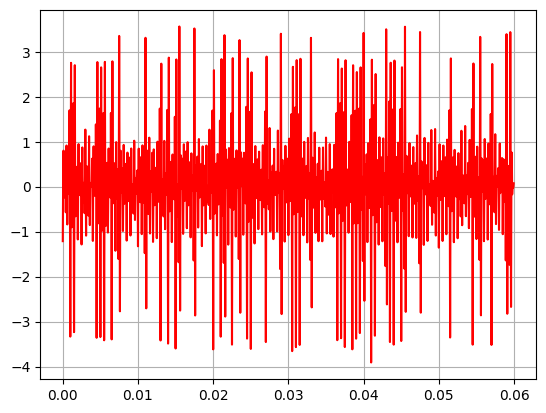

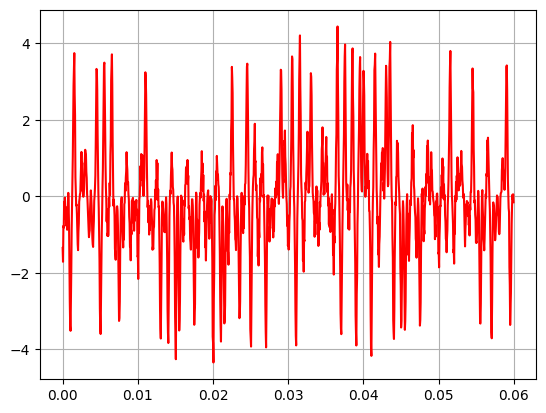

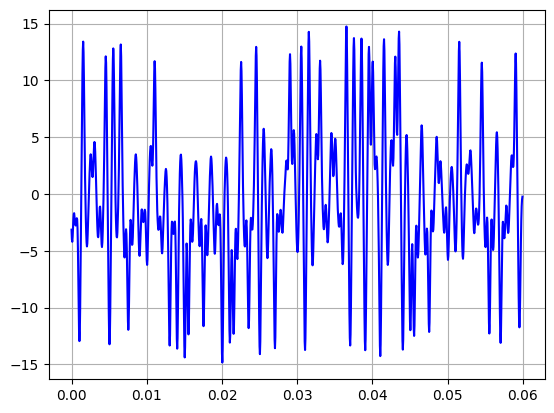

[-1 -1 -3  3 -1  1  1 -1 -1  3 -3  3 -1  3 -1 -3 -1  1 -1 -1 -1  1  3 -1
 -1  1 -3 -1 -3  1 -3 -3 -1  1 -1 -3 -1  1 -1 -1 -3  1 -3 -3 -1  3 -1 -3
 -1  3 -3  1 -1  1 -3 -1 -1  1  3  1 -1  3 -3  3 -1  1  3 -1 -1  1  1 -1
 -1  3 -3  3 -1  3 -3  3  3  1 -3  3 -1  1  3  3 -3  1 -3 -3 -1  1 -1 -3
 -1  1  1 -1 -1  1 -1  3 -1  1  1 -1 -1  3 -1 -3 -1  1 -3 -1 -1  1  3 -3]
[-1 -1 -3  3 -1  1  1 -1 -1  3 -3  3 -1  3 -1 -3 -1  1 -1 -1 -1  1  3 -1
 -1  1 -3 -1 -3  1 -3 -3 -1  1 -1 -3 -1  1 -1 -1 -3  1 -3 -3 -1  3 -1 -3
 -1  3 -3  1 -1  1 -3 -1 -1  1  3  1 -1  3 -3  3 -1  1  3 -1 -1  1  1 -1
 -1  3 -3  3 -1  3 -3  3  3  1 -3  3 -1  1  3  3 -3  1 -3 -3 -1  1 -1 -3
 -1  1  1 -1 -1  1 -1  3 -1  1  1 -1 -1  3 -1 -3 -1  1 -3 -1 -1  1  3 -3]
Sistema de transmissão digital


In [ ]:
#Metade da Amplitude máxima do quantizador
d = 3/2

#Loop do controle automático de ganho
x_r = AGC(x_r,d,1000,0.01)


plt.plot(t_x,x_r,color = 'red')
plt.grid()
plt.show()


#Demodulação
x_cos = x_r*np.cos(2*np.pi*(fc+gamma)*t_x)


# Filtro demodulador
B = 5000
Fn = Fs/2
delta_f = 100
fs1 = B + delta_f
fp1 = fs1 - delta_f/2


# Parâmetros do filtro
f = [0, fp1, fs1, Fn]  # Faixas normalizadas
a = [1,0]  # Especificação do ganho (0 na primeira faixa, 1 na segunda)
fl = 200  # Ordem do filtro


# Projeto do filtro usando a função remez
h = remez(fl + 1, f, a, fs = Fs)  # remez exige a frequência de amostragem e ja faz a normalização

x_demod = 2*np.convolve(x_cos, h,'same')


plt.plot(t_x,x_demod,color = 'red')
plt.grid()
plt.show()


#Correlação
y = np.correlate(x_demod,p_hamming,'same')
t_y = np.arange(0,len(y)*Ts,Ts)

plt.plot(t_y,y,color = 'blue')
plt.grid()
plt.show()



#Subamostragem e normalização
z = y[::M]/np.sum(p_hamming**2)
t_z = np.arange(0,len(z)*Ts,Ts)
# plt.plot(t_z,z,color = 'blue')
# plt.grid()
# plt.show()




#Quantização
niveis = np.array([-3,-1,1,3])
m_prime = quantizador(z,niveis)

print(m_prime)
print(s)

#Decodificação
string_rec = pamdecod(m_prime)
print(string_rec)

# num_errors = np.sum(np.abs(m_prime-s)]))
# print(f'Número de erros: {num_errors}')